In [4]:
import random
import argparse
import json
import os
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl

from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.optimization import Adafactor, AdafactorSchedule, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.loggers import CSVLogger, WandbLogger  # Import WandbLogger

import sys
sys.path.append('/home/OmniFusion-Merge-of-Encoders/')
from OmniFusion.merge_of_encoders.encoders.clip import CLIPVisionTower
from OmniFusion.merge_of_encoders.encoders.utils import initialize_special_embs
from OmniFusion.merge_of_encoders.adapters import VisualToGPTMapping
from OmniFusion.merge_of_encoders.datasets.tex_recognition_dataset import get_dataset, get_collate_function
import requests
from OmniFusion.merge_of_encoders.encoders.texify import TexifyVisionTower

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
cfg = {
    "exp_name": "texify-default-pretrain",
    "model_ckp": "Qwen/Qwen2-0.5B",
    # "clip_adapter_ckp": "/home/OmniFusion-Merge-of-Encoders/OmniFusion/merge_of_encoders/training/ckpts/projection_qwen05.pth",
    # "special_embs_ckp": "/home/OmniFusion-Merge-of-Encoders/OmniFusion/merge_of_encoders/training/ckpts/special_embeds_qwen05.pth",
    # "encoder_ckp": "/home/OmniFusion-Merge-of-Encoders/OmniFusion/merge_of_encoders/training/ckpts/texify-default-pretrain/version_5/texify_projection.pt",
    "n_epochs": 1,
    "grad_accum": 4,
    "learning_rate": 1e-2,
    "prompt": "This is a dialog with AI assistant.\n",
    "num_workers": 16,
    "batch_size": 6,
    "emb_dim": 896,
    "max_context_len": 2048,
    "vision_emb_num": 576,
    "encoder_emb_num": 576,
    "projection_num_head": 4,
    "json_data_path": "path_to_your_dataset.json",
    "image_folder": "path_to_your_images_folder"
}


In [28]:
DEVICE = "cuda:2"
PROMPT = "This is a dialog with AI assistant.\n"

In [29]:
DTYPE = torch.float16


### Define models
tokenizer = AutoTokenizer.from_pretrained(cfg["model_ckp"], use_fast=False)
unk_id = tokenizer.encode("<unk>", add_special_tokens=False)[0]

# Initialize Wandb logger
# wandb_logger = WandbLogger(project="merge_of_encoders", name=cfg.exp_name)

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B", torch_dtype=DTYPE, device_map='cuda:2')

clip = CLIPVisionTower("openai/clip-vit-large-patch14-336")
clip.load_model()
clip = clip.to(dtype=DTYPE, device=DEVICE)

encoder = TexifyVisionTower() # TODO: codetr, plots, ocr, etc.
encoder.load_model()
encoder = encoder.to(dtype=DTYPE, device=DEVICE)

Loaded texify model to cuda with torch.float16 dtype
Loaded texify model to cuda with torch.float16 dtype


In [52]:
projection = VisualToGPTMapping(1024, cfg["emb_dim"], cfg["vision_emb_num"]).to(dtype=DTYPE, device=DEVICE)
projection = torch.load("/home/OmniFusion-Merge-of-Encoders/OmniFusion/merge_of_encoders/training/ckpts/texify-default-pretrain/version_5/texify_projection.pt")
# projection.transformer_layer.norm_first = False

clip_projection = VisualToGPTMapping(1024, cfg["emb_dim"], cfg["vision_emb_num"]).to(dtype=DTYPE, device=DEVICE)
clip_projection = torch.load("/home/OmniFusion-Merge-of-Encoders/OmniFusion/merge_of_encoders/training/ckpts/texify-default-pretrain/version_5/projection.pt")
# clip_projection.transformer_layer.norm_first = False

# special_embs = initialize_special_embs(emb_dim=cfg.emb_dim, device='cpu', dtype=DTYPE)
special_embs = torch.load("/home/OmniFusion-Merge-of-Encoders/OmniFusion/merge_of_encoders/training/ckpts/texify-default-pretrain/version_5/special_embeddings.pt")

AttributeError: 'dict' object has no attribute 'to'

In [59]:
def gen_answer(model, tokenizer, 
            #    clip, projection, 
               query, special_embs, image=None, 
            #    venc=None
               ):
    bad_words_ids = tokenizer(["\n", "</s>", ":"], add_special_tokens=False).input_ids + [[13]]
    gen_params = {
        "do_sample": False,
        "max_new_tokens": 50,
        "early_stopping": True,
        "num_beams": 3,
        "repetition_penalty": 1.0,
        "remove_invalid_values": True,
        "eos_token_id": 2,
        "pad_token_id": 2,
        "forced_eos_token_id": 2,
        "use_cache": True,
        "no_repeat_ngram_size": 4,
        "bad_words_ids": bad_words_ids,
        "num_return_sequences": 1,
    }
    with torch.no_grad():
        # image_features = clip.image_processor(image, return_tensors='pt')
        # image_embedding = clip(image_features['pixel_values']).to(device=DEVICE, dtype=torch.bfloat16)
        
        clip.requires_grad_(False)
        encoder.requires_grad_(False)
    
        
        clip_embs = clip.image_processor(image, return_tensors='pt')['pixel_values'].to(device=DEVICE, dtype=torch.bfloat16)
        tex_embs = encoder.image_processor(image, return_tensors='pt')['pixel_values'].to(device=DEVICE)
        
        clip_embs = clip(clip_embs)
        tex_embs = encoder(tex_embs)
        with torch.cuda.amp.autocast():
            projected_clip_embeddings = clip_projection(clip_embs)
            projected_encoder_embeddings = projection(tex_embs)
        
        projected_vision_embeddings = torch.cat([
            projected_clip_embeddings, projected_encoder_embeddings
        ], dim=1).to(DEVICE)
        
        # projected_vision_embedding = projection(image1_embedding).to(device=DEVICE, dtype=torch.bfloat16
        prompt_ids = tokenizer.encode(f"{PROMPT}", add_special_tokens=False, return_tensors="pt").to(device=DEVICE)
        question_ids = tokenizer.encode(query, add_special_tokens=False, return_tensors="pt").to(device=DEVICE)

        prompt_embeddings = model.model.embed_tokens(prompt_ids).to(torch.bfloat16)
        question_embeddings = model.model.embed_tokens(question_ids).to(torch.bfloat16)

        print(projected_vision_embeddings.shape, prompt_embeddings.shape, question_embeddings.shape)

        embeddings = torch.cat(
            [
                prompt_embeddings.to(DEVICE),
                special_embs['SOI'][None, None, ...].to(DEVICE),
                projected_vision_embeddings.to(DEVICE),
                special_embs['EOI'][None, None, ...].to(DEVICE),
                special_embs['USER'][None, None, ...].to(DEVICE),
                question_embeddings.to(DEVICE),
                special_embs['BOT'][None, None, ...].to(DEVICE)
            ],
            dim=1,
        ).to(dtype=torch.bfloat16, device=DEVICE)
        with torch.cuda.amp.autocast():
            out = model.generate(inputs_embeds=embeddings, **gen_params)
    out = out[:, 1:]
    generated_texts = tokenizer.batch_decode(out)[0]
    return (
        clip_embs, 
        tex_embs,
        projected_vision_embeddings, 
        prompt_ids,
        question_ids,
        prompt_embeddings,
        question_embeddings
    ), generated_texts


In [75]:
from PIL import Image
from urllib.request import urlopen
img_url = "https://media.architecturaldigest.com/photos/5a78d7137d67ba0e58c35ec8/2:1/w_1280%2Cc_limit/architecture-1853552_1920.jpg"
question = "Describe this picture "
img = Image.open(urlopen(img_url))

In [127]:
from PIL import Image
from urllib.request import urlopen
img_url = "/home/Img2latex/test2.jpg"
question = "What mathematical symbols are present in this image?"
img = Image.open(img_url)

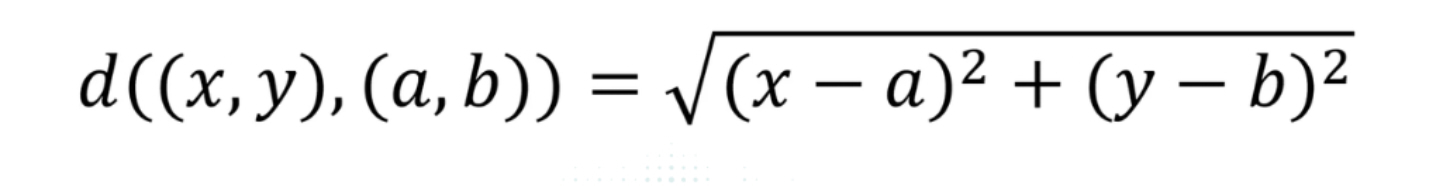

In [128]:
img

In [129]:
answer = gen_answer(
    model,
    tokenizer,
    query=question,
    special_embs=special_embs,
    image=img,
)


torch.Size([1, 1152, 896]) torch.Size([1, 8, 896]) torch.Size([1, 9, 896])


In [130]:
answer[1]

'begin{align*} \\mathcal{L} &= \\sum_{i=0}^{n-1} \\sum_{j=0}^n \\sum_{k=0}^\\infty \\frac{1}{#'